In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample

import torch

from datasets import load_dataset, Dataset
from datasets import Features, Value, ClassLabel

from transformers import BertTokenizer
from transformers import BertForSequenceClassification

from transformers import Trainer, TrainingArguments
import numpy as np
import evaluate

/Users/gabrielasiqueiraeduardo/miniforge3/envs/unstructured_nlp/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Load dataset

#### pandas dataset

In [2]:
df = pd.read_csv('dataset/dataset.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [4]:
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [6]:
# contagem simples de "palavras"
df['text_length'] = df['text'].apply(lambda x: len(x.split(' ')))

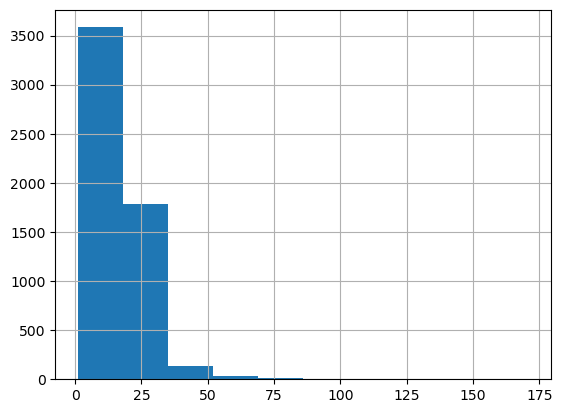

In [7]:
df['text_length'].hist();

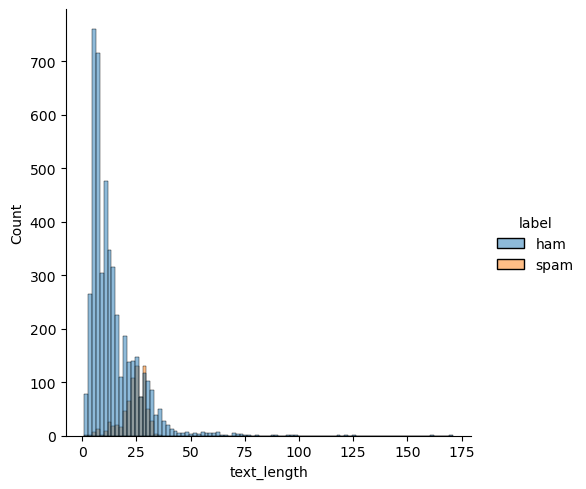

In [8]:
sns.displot(x='text_length', data=df, hue='label');

In [9]:
# balance classes

df_spam = df[df['label'] == 'spam']
df_ham = df[df['label'] == 'ham']

# undersampling
df_downsampled = resample(df_ham, replace=False, n_samples=len(df_spam), random_state=42)

df_balanced = pd.concat([df_downsampled, df_spam])

In [10]:
df_balanced.label.value_counts()

ham     747
spam    747
Name: label, dtype: int64

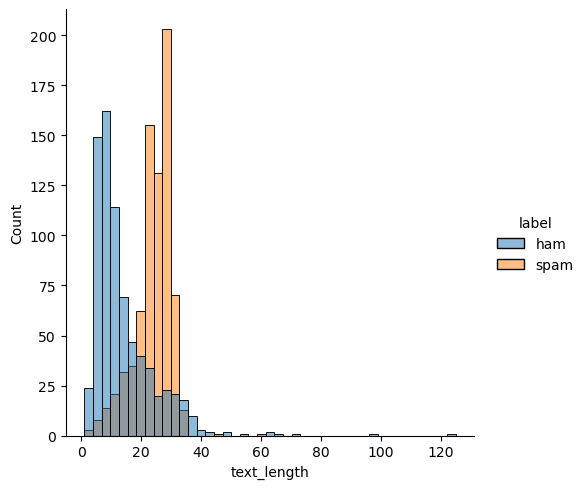

In [11]:
# ham text < spam text
sns.displot(x='text_length', data=df_balanced, hue='label');

In [12]:
df_balanced.drop(columns=['text_length']).to_csv('dataset/spam_downsampled.csv', index=False)

In [13]:
df = pd.read_csv('dataset/spam_downsampled.csv')

In [14]:
df.head()

,label,text
0,ham,"I am late,so call you tomorrow morning.take ca..."
1,ham,U r too much close to my heart. If u go away i...
2,ham,Wait &lt;#&gt; min..
3,ham,Can you call me plz. Your number shows out of ...
4,ham,MAYBE IF YOU WOKE UP BEFORE FUCKING 3 THIS WOU...


#### torch dataset

In [15]:
class_names = ['ham', 'spam']

ft = Features({'text': Value('string'), 'label': ClassLabel(names=class_names)})

In [16]:
dataset = load_dataset('csv', data_files=['dataset/spam_downsampled.csv'], features=ft)['train'].train_test_split(train_size=.8, test_size=.2, stratify_by_column="label")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [17]:
dataset_train = dataset['train'].shuffle(seed=42)
dataset_test = dataset['test'].shuffle(seed=42)

## BERT tokenizer

In [18]:
model_id = "bert-base-cased"

tokenizer = BertTokenizer.from_pretrained(model_id, do_lower_case=False)

In [19]:
token_length = list()
for text in df['text']:
    tokens = tokenizer.tokenize(text)
    token_length.append(len(tokens))

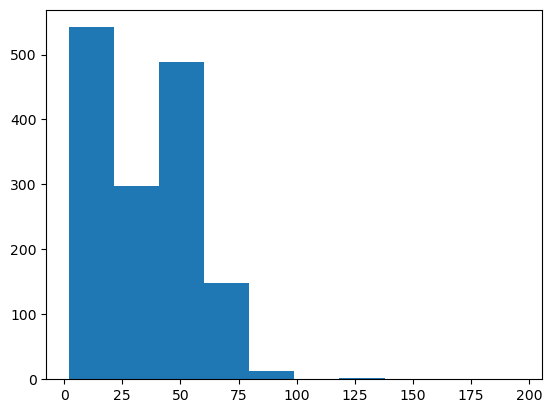

In [20]:
# token lenght < max_length  --- no need for chunking method
plt.hist(token_length);

In [21]:
def tokenization(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=512)

dataset = dataset.map(tokenization, batched=True, remove_columns=["text"])
dataset

Map:   0%|          | 0/1195 [00:00<?, ? examples/s]

Map:   0%|          | 0/299 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1195
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 299
    })
})

In [22]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'mps'
device

'mps'

In [23]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [24]:
model = BertForSequenceClassification.from_pretrained(model_id, num_labels=2)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [25]:
training_args = TrainingArguments(
    output_dir="spam_torch",
    per_device_train_batch_size=8, 
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    logging_steps=1000,
    load_best_model_at_end=True,
    seed=42
)

In [26]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

/Users/gabrielasiqueiraeduardo/miniforge3/envs/unstructured_nlp/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

{'eval_loss': 0.10091949254274368, 'eval_accuracy': 0.9732441471571907, 'eval_runtime': 12.3038, 'eval_samples_per_second': 24.302, 'eval_steps_per_second': 3.088, 'epoch': 1.0}


  0%|          | 0/38 [00:00<?, ?it/s]

{'eval_loss': 0.07392244040966034, 'eval_accuracy': 0.9832775919732442, 'eval_runtime': 12.0647, 'eval_samples_per_second': 24.783, 'eval_steps_per_second': 3.15, 'epoch': 2.0}
{'train_runtime': 404.2563, 'train_samples_per_second': 5.912, 'train_steps_per_second': 0.742, 'train_loss': 0.14757570902506512, 'epoch': 2.0}


TrainOutput(global_step=300, training_loss=0.14757570902506512, metrics={'train_runtime': 404.2563, 'train_samples_per_second': 5.912, 'train_steps_per_second': 0.742, 'train_loss': 0.14757570902506512, 'epoch': 2.0})

## Validation

In [27]:
def predict(text):
    encoding = tokenizer(text, padding="max_length", truncation=True, max_length=512, return_tensors='pt').to(device)
    outputs = model(**encoding)
    preds = torch.sigmoid(outputs.logits)
    return preds

In [28]:
texts = [
    "Hey! Just wanted to remind you about our dinner plans tonight at 7 PM. Can't wait to catch up!", # ham
    "Your prescription is ready for pickup at the pharmacy. Please stop by at your convenience.", # ham
    "Hi, this is John from the office. Could you please bring the report to the meeting room in 10 minutes? Thanks!", # ham
    "Congratulations! You've won a $1000 gift card. Claim it now by clicking the link: bit.ly/claimprize123", # spam
    "Urgent: Your entry was selected! You've won a luxury vacation for two. Call now to claim: 555-1234.", # spam
    "FreeMsg: You have been selected for a free iPhone 12! Reply 'YES' to claim your prize. T&C apply." # spam
        ]


In [29]:
for text in texts:
    print(text)
    preds = predict(text)
    print(f'Ham: {preds[0][0]}, Spam: {preds[0][1]}')

Hey! Just wanted to remind you about our dinner plans tonight at 7 PM. Can't wait to catch up!
Ham: 0.8807941675186157, Spam: 0.05279671400785446
Your prescription is ready for pickup at the pharmacy. Please stop by at your convenience.
Ham: 0.8791549205780029, Spam: 0.0743674486875534
Hi, this is John from the office. Could you please bring the report to the meeting room in 10 minutes? Thanks!
Ham: 0.8974767923355103, Spam: 0.08332327753305435
Congratulations! You've won a $1000 gift card. Claim it now by clicking the link: bit.ly/claimprize123
Ham: 0.07122800499200821, Spam: 0.958004891872406
Urgent: Your entry was selected! You've won a luxury vacation for two. Call now to claim: 555-1234.
Ham: 0.08428699523210526, Spam: 0.9503592252731323
FreeMsg: You have been selected for a free iPhone 12! Reply 'YES' to claim your prize. T&C apply.
Ham: 0.1140844076871872, Spam: 0.93597412109375
